# Semantic Segmentation of Water using U-Net

The purpose of this project is to experiment with different U-Net architectures and hyperparameters to show how semantic segmentation of water/non-water pixels can be achieved and subsequently how model performance can be improved.

The training data used here comes from the [NWPU-REISIC dataset](https://arxiv.org/abs/1703.00121). Specifically I have used the lake category which comprises 700 images of dimensions 256 x 256 x 3 (R,G,B) containing uint8 data (0 - 255). This is a relatively small dataset for this task but is used here, due to computing constraints, to serve as a proof of concept.

# Part 1 - Data Preparation

In this first section I load the training data and build routines for generating corresponding mask images from the labels. I have already created labels in JSON format for the some of the lake images using [Make Sense](https://www.makesense.ai/).

<div class="alert alert-block alert-info"><b>Note:</b><br>The Make Sense interface does not allow the creation of polygons with holes so I have performed a somewhat crude labelling to avoid islands in lakes. Further, the labeling process is very time consuming so at present only 400 images have been labelled.<br><br>With these point in mind there is certainly room for improvement!
</div>

If the data are not yet downloaded they can be accessed via OneDrive at https://1drv.ms/u/s!AmgKYzARBl5ca3HNaHIlzp_IXjs as specified in the Tensorflow [documentation](https://www.tensorflow.org/datasets/catalog/resisc45).

In [3]:
import glob
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import shutil

import numpy as np
from skimage.draw import polygon
from skimage.io import imread, imsave, imshow

from PIL import Image, ImageDraw

In [4]:
# Image directories
nwpu_data_dir = os.path.join('nwpu_lake_images','data')
nwpu_mask_dir = os.path.join('nwpu_lake_images','masks')

# Label directory
nwpu_label_dir = 'nwpu_lake_labels'

In [28]:
# Get list of all training images
all_imgs = glob.glob(os.path.join(nwpu_data_dir,'*.jpg'))

# Create DataFrame to hold image-label information
label_info = pd.DataFrame({'img_name':sorted([os.path.basename(i) for i in all_imgs]),
                           'has_labels':False})

In [29]:
# Combine all lakes label files
label_files = glob.glob(os.path.join(nwpu_label_dir,'nwpu_lakes_*.json'))

labels_merged = dict()
for lf in label_files:
    j = json.load(open(lf))
    labels_merged.update(j)

labelled_imgs = labels_merged.keys()

# update dataframe
label_info['has_labels'] = label_info.apply(lambda x: x.img_name in labelled_imgs, axis=1)

In [30]:
label_info

,img_name,has_labels
0,lake_001.jpg,True
1,lake_002.jpg,True
2,lake_003.jpg,True
3,lake_004.jpg,True
4,lake_005.jpg,True
...,...,...
695,lake_696.jpg,False
696,lake_697.jpg,False
697,lake_698.jpg,False
698,lake_699.jpg,False


In [12]:
label_info.has_labels.value_counts()

True     400
False    300
Name: has_labels, dtype: int64

<div class="alert alert-block alert-info"><b>Note:</b><br>I still have 300 images left to label but at this point I will work with the 400 labelled images.</div>

## Creating Label Masks

In this section I will use the polgon labels to create mask images corresponding to each of the labelled images. This will be an image with pixel values of 255 where water is present and 0 otherwise.

In [15]:
def labels2mask(img_path, labels_dict, out_path=None, out_ext=None, mask_val=255,
                dtype=np.uint8, overwrite=True, **kwargs):
    """Convert label coordinates to label image.
    
    The coordinates must be in units of image pixels.
    """
    
    # launder output file path
    if out_path is None:
        out_path = '_mask'.join(os.path.splitext(img_path))
        
    if out_ext:
        out_path = os.path.splitext(out_path)[0] + f'.{out_ext.lower()}'
        
    # handle overwrite
    if os.path.exists(out_path):
        if not overwrite:
            return out_path
    
    # get water polygon info
    img_name = os.path.basename(img_path)
    regions = labels_dict[img_name]['regions']
    
    
    # create mask array
    mask_shp = imread(img_path).shape[:2] # output is only 2D as opposed to the 3 channel input image
    mask_arr = np.zeros(mask_shp, dtype=dtype) 
    
    # Cycle through regions and set corresponsing pixels to mask_val
    for region_num, region_shape in regions.items():
        x = region_shape['shape_attributes']['all_points_x']
        y = region_shape['shape_attributes']['all_points_y']
        r,c = polygon(y, x, mask_shp) # The skimage polygon function requires coordinates as rows, cols
        mask_arr[r, c] = mask_val
    
    # write to new image   
    imsave(out_path, mask_arr, check_contrast=False, **kwargs)
    
    return out_path

In [16]:
def plot_labels(img_path, label_path, overlay=False, **plot_kwargs):
    """Plot source image and label image.
    """
    
    original = imread(img_path)
    labelled = imread(label_path)
    
    if not overlay:
        fig, axes = plt.subplots(1,2, **plot_kwargs)
        axes = axes.flatten()
        
        axes[0].imshow(original)
        axes[0].axis('off')
        axes[0].set_title('Original')

        axes[1].imshow(labelled, cmap='gray')
        axes[1].axis('off')
        axes[1].set_title('Labelled')
        
    else:
        fig, ax = plt.subplots(1,1, **plot_kwargs)
        ax.imshow(original)
        ax.imshow(labelled, cmap='bwr_r', alpha=0.4)
        ax.axis('off')

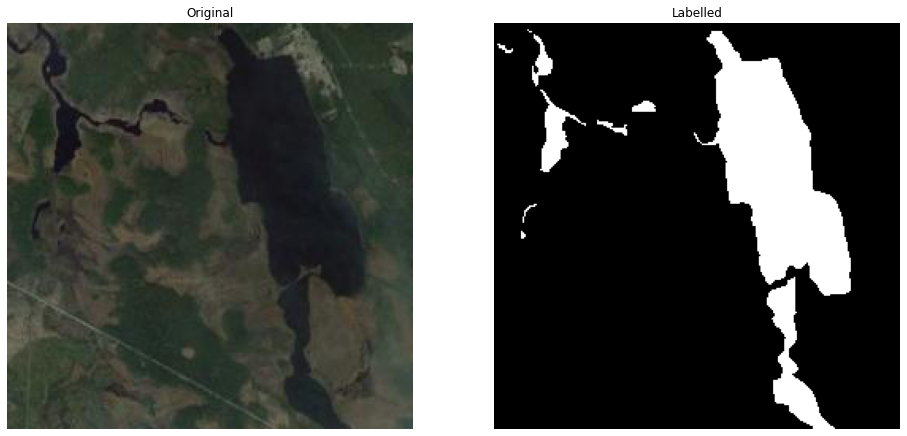

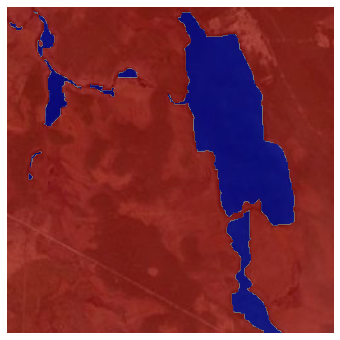

In [25]:
# Test on a sample image
rand_idx = np.random.randint(0,len(label_info[label_info.has_labels]))
img_path = os.path.join(nwpu_data_dir,
                        label_info[label_info.has_labels].img_name.iloc[rand_idx])

label_path = labels2mask(img_path, labels_merged, out_ext='PNG', overwrite=False)

plot_labels(img_path, label_path, figsize = (16,16))
plot_labels(img_path, label_path, figsize = (6,6), overlay=True)

Now process all images that have labels and move to a new directory

In [204]:
# Loop over all the images with lables and create the
# corresponding mask images. I save the masks in PNG
# format so that no compression takes place therefore
# leaving the values unmodified.
for img in label_info.img_name[label_info.has_labels]:
    img_path = os.path.join(nwpu_data_dir, img)
    labels2mask(img_path, labels_merged, out_ext='PNG')

In [194]:
# Make directory for mask images
nwpu_mask_dir = os.path.join('nwpu_lake_images','masks')
if not os.path.exists(nwpu_mask_dir):
    os.mkdir(nwpu_mask_dir)

# By default the masks are saved to the same directory as
# the source images. This step moves the masks to the
# dedicated directory.
mask_files = glob.glob(os.path.join(nwpu_data_dir,'*_mask.png'))
for mf in mask_files:
    shutil.move(mf,nwpu_mask_dir)

In [320]:
# Finally, ensure no masks left in image directories

for f in glob.glob(os.path.join(nwpu_data_dir,'*_mask.*')):
    os.remove(f)

Now each image for which labels have been created has a corresponding mask. If more images are labelled this code can be rerun to update the masks.

In [9]:
def get_lakes_with_masks(img_dir, mask_dir, return_masks=True, img_ext='jpg', mask_ext='png'):
    """ Determine lake images that have corresponding masks.
    
    Valid images are those that have a corresponding mask in
    mask_dir.
    
    """
    img_fns = sorted([fn for fn in os.listdir(img_dir) if fn.endswith(img_ext)]) 
    msk_fns = sorted([fn for fn in os.listdir(mask_dir) if fn.endswith(mask_ext)])
    
    img_fns = sorted(filter(lambda fn: f'{os.path.splitext(fn)[0]}_mask.png' in msk_fns,
                            img_fns)
                    )
    if return_masks:
        result = np.array(img_fns), np.array(msk_fns)
    else:
        result = np.array(img_fns)
    
    return result

In [10]:
valid_images, valid_masks = get_lakes_with_masks(nwpu_data_dir, nwpu_mask_dir)
print(len(valid_images), len(valid_masks))
print(valid_images[:10])
print(valid_masks[:10])

400 400
['lake_001.jpg' 'lake_002.jpg' 'lake_003.jpg' 'lake_004.jpg'
 'lake_005.jpg' 'lake_006.jpg' 'lake_007.jpg' 'lake_008.jpg'
 'lake_009.jpg' 'lake_010.jpg']
['lake_001_mask.png' 'lake_002_mask.png' 'lake_003_mask.png'
 'lake_004_mask.png' 'lake_005_mask.png' 'lake_006_mask.png'
 'lake_007_mask.png' 'lake_008_mask.png' 'lake_009_mask.png'
 'lake_010_mask.png']
